# Install and Import Necessary Libaries

In [2]:
pip install keras-unet-collection


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 21.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
from keras_unet_collection import models, losses
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import os
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam


# Model Training

In [6]:
#Size of the image used in training
SIZE_X = 256  
SIZE_Y = 256
n_classes=3 #Number of classes for segmentation

In [7]:
def standardize(img):
    # Standardization of images using adjusted standard deviation

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0 / np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img) == 2:
        img = np.dstack((img, img, img))

    return img

In this cell, change the `im_path` and `mask_path` to folders where your training set is

In [8]:
#Capture mask/label info as a list


train_masks = [] 
train_images = []

mask_path = "/notebooks/Augmented_New/Masks/" # Path to Masks 
im_path = "/notebooks/Augmented_New/NIR/" # Path to Images
                               
maskDisO = os.listdir(mask_path)
maskNames = sorted(maskDisO)

imDisO = os.listdir(im_path)
imNames = sorted(imDisO)


for mask in maskNames: 
  for im in imNames:
    #look through each image for each mask
    if mask == im and mask.endswith(".jpg"):#checks for substring match (image name)
      #read images
      maskArr = cv2.imread(mask_path+mask, 0)
      imArr = cv2.imread(im_path+im)
      #resize images
      maskArr = cv2.resize(maskArr,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)
      imArr = cv2.resize(imArr,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)
      #append to mask and image lists
      train_masks.append(maskArr)
      train_images.append(imArr)


#Convert lists to array      

train_masks = np.array(train_masks)


print(str(train_masks.shape)+"\n"+str(train_masks.size))
train_images = np.array(train_images)
print(str(train_images.shape)+"\n"+str(train_images.size))

normalRGBtrain = [] #mask images resized
RGBorig = [] #images resized

# Convert all Images from BRG to RGB
for imgIdx in range(train_images.shape[0]):
    
  img = train_images[imgIdx]

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = standardize(img)

  RGBorig.append(img)


train_images = np.array(RGBorig)

for imgIdx in range(train_masks.shape[0]):

  img = train_masks[imgIdx]

  #threshold to isolate ocean pixels
  ret,ocean = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV)
  #threshold to isolate reef pixels
  ret,reef = cv2.threshold(img,1,255,cv2.THRESH_BINARY)
  #threshold to isolate land and reef pixels
  ret,reefLand = cv2.threshold(img,0,255,cv2.THRESH_BINARY)
  #subtracting reef from reef and land gives us land
  land = reefLand - reef
  #new list for JUST this image
  label = []
  #add reef as its own channel
  label.append(reef)
  #add land as its own channel
  label.append(land)
  #add ocean as its own channel
  label.append(ocean)
  #convert list to array, makes this a new image!
  label = np.array(label)
  #now need to match input and switch axes around
  label = np.swapaxes(label, 0,1)
  label = np.swapaxes(label, 1,2)
  #normalize values of label
  label = label/255

  normalRGBtrain.append(label)


#make array with all of our new arrays
train_masks = np.array(normalRGBtrain)

#checks that maskset and imageset are same size 
print(train_masks.shape)
print(train_images.shape)

(1939, 256, 256)
127074304
(1939, 256, 256, 3)
381222912
(1939, 256, 256, 3)
(1939, 256, 256, 3)


Apply augmentation here if needed. If dataset is already augmented, skip this cell.

In [59]:
# Augmentation of Dataset if needed. Does rotation 3 times. 
im = []
msk = []

for i in range(train_masks.shape[0]):
    
    rotate = cv2.rotate(train_images[i], cv2.ROTATE_90_CLOCKWISE)
    maskTwoRotate = cv2.rotate(rotate, cv2.ROTATE_90_CLOCKWISE)
    maskThreeRotate = cv2.rotate(maskTwoRotate, cv2.ROTATE_90_CLOCKWISE)
    
    rotate2 = cv2.rotate(train_masks[i], cv2.ROTATE_90_CLOCKWISE)
    maskTwoRotate2 = cv2.rotate(rotate2, cv2.ROTATE_90_CLOCKWISE)
    maskThreeRotate2 = cv2.rotate(maskTwoRotate2, cv2.ROTATE_90_CLOCKWISE)
    
    
    im.append(train_images[i])
    msk.append(train_masks[i])
    im.append(rotate)
    msk.append(rotate2)
    im.append(maskTwoRotate)
    msk.append(maskTwoRotate2)
    im.append(maskThreeRotate)
    msk.append(maskThreeRotate2)

    
train_images = np.array(im)
train_masks = np.array(msk)

Split the data into training and validation sets

In [9]:
#Create a subset of data for quick testing
from sklearn.model_selection import train_test_split

#here need to split data and order in a way that makes index in array correspond to particular image-mask pair
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.2, random_state = 0)

from keras.utils import to_categorical

# Model Selection

Pick one of the below models for training. Change the parameters as see fit. Documentation here: https://github.com/yingkaisha/keras-unet-collection

In [11]:
model = models.transunet_2d((256, 256, 3), filter_num=[64, 128, 256, 512], n_labels=3, stack_num_down=2, stack_num_up=2,
                                embed_dim=768, num_mlp=3072, num_heads=3, num_transformer=3,
                                activation='ReLU', mlp_activation='GELU', output_activation='Softmax', 
                                batch_norm=True, pool=True, unpool='bilinear', name='transunet')

In [181]:
model = models.unet_plus_2d((256, 256, 3), [64, 128, 256, 512], n_labels=3,
                            stack_num_down=2, stack_num_up=2,
                            activation='LeakyReLU', output_activation='Softmax', 
                            batch_norm=False, pool='max', unpool=False, deep_supervision=True, name='xnet')

----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	xnet_output_sup0_activation
	xnet_output_sup1_activation
	xnet_output_sup2_activation
	xnet_output_final_activation


In [26]:
model = models.swin_unet_2d((256, 256, 3), filter_num_begin=64,
                               n_labels=3, depth=4, stack_num_down=2, stack_num_up=2,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Softmax', shift_window=True,
                               name='swin_unet')

In [165]:
model = models.resunet_a_2d((256, 256, 3), [32, 64, 128, 256], 
                            dilation_num=[1, 3, 15, 31], 
                            n_labels=3, aspp_num_down=256, aspp_num_up=128, 
                            activation='ReLU', output_activation='Sigmoid', 
                            batch_norm=True, pool=False, unpool='nearest', name='resunet')

Received dilation rates: [1, 3, 15, 31]
Received dilation rates are not defined on a per downsampling level basis.
Automated determinations are applied with the following details:
	depth-0, dilation_rate = [1, 3, 15, 31]
	depth-1, dilation_rate = [1, 3, 15, 31]
	depth-2, dilation_rate = [1, 3, 15]
	depth-3, dilation_rate = [1]


In [38]:
model = models.att_unet_2d((256, 256, 3), [64, 128, 256, 512], n_labels=3,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU', atten_activation='ReLU', attention='add', output_activation=None, 
                           batch_norm=True, pool=False, unpool='bilinear', name='attunet')

Compile the model before continuing

In [27]:
# Compile model before training and get a summary over structure
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', losses.iou_seg])
print(model.summary())

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract_2 (patch_extract  (None, 4096, 48)    0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 patch_embedding_2 (patch_embed  (None, 4096, 64)    265280      ['patch_extract_2[0][0]']        
 ding)                                                                              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Run the cell below for training. Change parameters as see fit

In [28]:
# Training
Unet_history = model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = 4,
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    epochs=10)



Epoch 1/10
388/388 [==============================] - 45s 79ms/step - loss: 0.0904 - accuracy: 0.9497 - iou_seg: 0.1271 - val_loss: 0.0735 - val_accuracy: 0.9572 - val_iou_seg: 0.1188
Epoch 2/10
388/388 [==============================] - 29s 74ms/step - loss: 0.0655 - accuracy: 0.9627 - iou_seg: 0.1032 - val_loss: 0.0633 - val_accuracy: 0.9637 - val_iou_seg: 0.1041
Epoch 3/10
388/388 [==============================] - 27s 70ms/step - loss: 0.0629 - accuracy: 0.9643 - iou_seg: 0.0996 - val_loss: 0.0674 - val_accuracy: 0.9604 - val_iou_seg: 0.1056
Epoch 4/10
388/388 [==============================] - 28s 71ms/step - loss: 0.0594 - accuracy: 0.9663 - iou_seg: 0.0946 - val_loss: 0.0594 - val_accuracy: 0.9652 - val_iou_seg: 0.0960
Epoch 5/10
388/388 [==============================] - 28s 71ms/step - loss: 0.0586 - accuracy: 0.9669 - iou_seg: 0.0932 - val_loss: 0.0575 - val_accuracy: 0.9668 - val_iou_seg: 0.0954
Epoch 6/10
388/388 [==============================] - 27s 70ms/step - loss: 0.05

In [65]:
# Save the model in hdf5 format somewhere
model.save('/notebooks/Todos_Everything/Swir2/Swir2.hdf5')

# Model Prediction

In [ ]:
# Load model if needed; otherwise, if you ran everything above, skip this step. 
from tensorflow.keras.models import load_model
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding, SwinTransformerBlock, patch_merging, patch_expanding
from keras_unet_collection.activations import GELU

model = load_model('/notebooks/All_Bands.hdf5', custom_objects = {"patch_extract":patch_extract, "patch_embedding": patch_embedding, "SwinTransformerBlock" : SwinTransformerBlock, "patch_merging": patch_merging, "patch_expanding": patch_expanding, "dice_coef" : losses.dice_coef, "GELU" : GELU, "dice" : losses.dice})


In [10]:
# Initialize lists to store training images and their filenames
train_predict = []
train_predict_list = []

# Define the path to the image folder and the image size
folder = "/Users/ray/Desktop/Test Set/NIR/"
SIZE_X = 256 # width of the image
SIZE_Y = 256 # height of the image

# Loop over all files in the folder
for directory_path in sorted(glob.glob(folder)):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        
        # Read each image file
        img = cv2.imread(img_path)
        # Convert the image from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image to the specified size
        img = cv2.resize(img,(SIZE_X,SIZE_Y), interpolation = cv2.INTER_CUBIC)

        # Standardize images for predictions
        img = standardize(img)
        # Append the standardized image to the train_predict list
        train_predict.append(img)

        # Extract the filename from the full path and append it to train_predict_list
        filename = os.path.basename(img_path)[:-4]
        train_predict_list.append(filename)

# Convert train_predict to numpy array
train_predict = np.array(train_predict)

print(train_predict.shape)  # Print out the shape of train_predict


(28, 256, 256, 3)


In [ ]:
ground_truth = []

# Define the path to the image folder and the image size
ground_folder = "/Users/ray/Desktop/Actual_Test_Set/"


# Loop over all files in the folder
for directory_path in sorted(glob.glob(folder)):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        
        # Read each image file
        img = cv2.imread(img_path,0)
       
        # Append the standardized image to the train_predict list
        ground_truth.append(img)


# Convert train_predict to numpy array
ground_truth = np.array(ground)

print(ground_truth.shape)  # Print out the shape of train_predict


# Predicting

In [30]:
predicted = []
for i in range(len(train_predict_list)):
  prediction = (model.predict(train_predict)) # Predict on image
  predicted_img=np.argmax(prediction, axis=3)[i,:,:] 
  predicted.append(predicted_img)
 

1/1 [==============================] - 0s 106ms/step


In [ ]:
# Save Predictions to a folder
save_folder = "/Users/ray/Desktop/folder/"
for i in range(len(predicted)):
    plt.imsave(save_folder + train_predict_list[i]+ ".png", predicted[i])

# Visualize Predictions

In [ ]:
for i in range(len(train_predict)):
    # Create a new figure
    plt.figure(figsize=(15,5))
    
    # Show the original image
    plt.subplot(1, 3, 1)
    plt.imshow(train_predict[i])
    plt.title(f'Image {i+1}')  # replace with actual image name if available
    
     # Show the ground truth
    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth[i])
    plt.title('Ground Truth')
    
    # Show the prediction
    plt.subplot(1, 3, 2)
    plt.imshow(predicted[i])
    plt.title('Prediction')

   
    # Show the figure
    plt.show()

# Compare Results with Ground Truth

Below, you can visualize and compare your prediction results to the ground truth. `cd` the library to somewhere with access to `Analysis.py`, then run

In [ ]:
%cd /Users/ray/Desktop/

Accuracy: 0.9651767185756138
F1 Score: 0.887999530393404
Mean IoU for each class: [0.96825179 0.68038317 0.79968608]
Overall Mean IoU: 0.8161070119153071


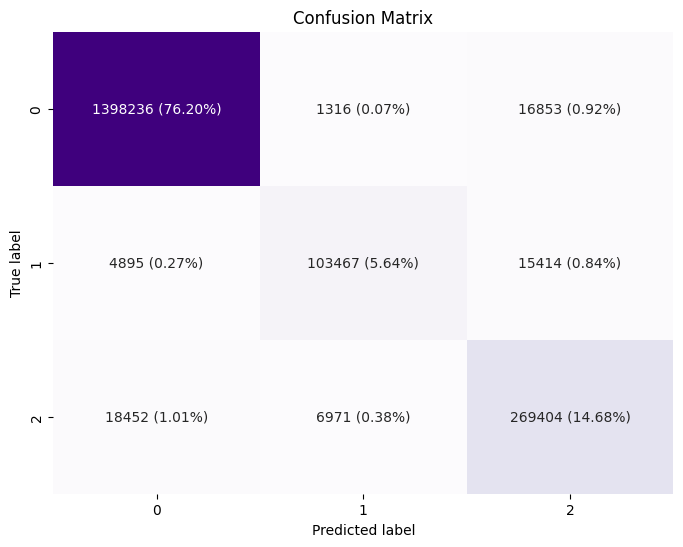

In [33]:
import Analysis
# Usage example
num_classes = 3
Ground_mask = predicted
true_mask = ground

analysis = Analysis.ImageAnalysis(num_classes, Ground_mask , true_mask)
analysis.compute_ious()
mean_ious, overall_mean_iou = analysis.get_mean_ious()
f1 = analysis.compute_f1()
accuracy = analysis.compute_accuracy()
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Mean IoU for each class: {mean_ious}')
print(f'Overall Mean IoU: {overall_mean_iou}')

analysis.plot_confusion_matrix()